From Linear Regression to Gaussian Processes
==========

In this notebook I want to explain how Gaussian Processes work and motivate its advantages and pitfalls.

_Max Zwiessele_

The code in this notebook uses the **development** version of GPy <https://github.com/SheffieldML/GPy/tree/devel>. 

You can download this notebook at <http://staffwww.dcs.sheffield.ac.uk/people/J.Hensman/notebooks/Hierarchical.ipynb>


Linear Regression
-------------------

One common problem in data analysis is the so called regression problem, where we have one or several input variables $\mathbf{X}\in\mathbb{R}^{n\times p}$ and want to fit the correlation from these variables to an output measurement $\mathbf{y}\in\mathbb{R}^{n\times 1}$. The most simple model to think of is the linear fit 

\begin{align}
\mathbf{y} &= c + \mathbf{X}\mathbf{w}\\
& = c + \sum_{i=1}^p w_i\mathbf{x}_{:i}\enspace,
\end{align}

which represents a line going through the data with an offset $c$ and a slope $w_i$ for each feature $i\in\{1\dots p\}$ ($\mathbf{w}\in\mathbb{R}^{p\times 1}$). In order to solve this problem, we first make use of matrix algebra and pull the offset $c$ into the parameter vector $\mathbf{w}$ by appending one feature of ones onto $\mathbf{X}$, resulting in out first design matrix $\boldsymbol{\Phi}=(\mathbf{1}, \mathbf{X})$ and writing the above equation without the intercept, which is now covered by the first parameter $w_0$

\begin{align}
\mathbf{y} = \boldsymbol{\Phi}\mathbf{w}\enspace.
\end{align}

This way of writing the equation lets us use linear algebra in order to find the optimal fit for the parameters $\mathbf{w}$

\begin{align}
\mathbf{y} &= \boldsymbol{\Phi}\mathbf{w}\\
\boldsymbol{\Phi}^\top\mathbf{y} &= \boldsymbol{\Phi}^\top\boldsymbol{\Phi}\mathbf{w}\\
(\boldsymbol{\Phi}^\top\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^\top\mathbf{y} &= \mathbf{w}
\end{align}

Here we will create some toy data, which will show the fit of this first simple linear model

In [1]:
import numpy as np, GPy, itertools, pandas as pd, seaborn as sns, sklearn.cross_validation as cv
%matplotlib inline
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.


In [2]:
n = 300

In [3]:
# define function to add the intercept on a design matrix:
def _add_intercept(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

# define linear design matrix with an intercept entry as first dimension
def linear(*args, **kwargs):
    def inner(X):
        return _add_intercept(X)
    return inner

# define convenience function for plotting data
def plot_data(X, y, cmap=None, ax=None, *args, **kwargs):
    if cmap is None:
        cmap = cm.coolwarm
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if not 'marker' in kwargs:
        kwargs['marker'] = 'x'
    if not 'linewidths' in kwargs:
        kwargs['linewidths'] = 1.5
    ax.scatter(*X.T, zs=y[:, 0], c=y[:, 0], cmap=cmap, **kwargs)
    return ax

training w_0 = 0.7500183767458323
training w_1 = -0.05671502817864502
training w_2 = 2.300674512710007


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


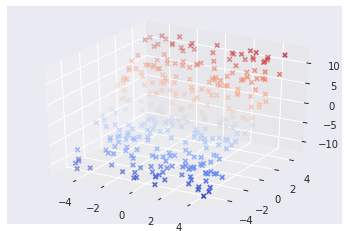

In [4]:
np.random.seed(12345)
X = np.random.uniform(-5, 5, (n, 2))
Phi = linear()(X)
w_train = np.random.normal(0, 1, (3, 1))
print('\n'.join(['training w_{} = {}'.format(i, float(w_train[i])) for i in range(w_train.shape[0])]))
y = Phi.dot(w_train) + np.random.normal(0, .4, (n, 1))

_ = plot_data(X, y)

Having this data, we can now create the first linear fit using the above formula.

In [5]:
# Prediction is the simple multiplication with the right parameters w
def predict_basis(Phi, w):
    return Phi.dot(w)

# convenience function to fit a dataset with a basis function `basis`
def fit_linear(Phi, y):
    return np.linalg.solve(Phi.T.dot(Phi), Phi.T.dot(y)), 0

def error(y_true, y_pred):
    StdE = np.sqrt(np.sum(np.square(y_true-y_pred))/(y_true.shape[0]*(y_true.shape[0]-1)))
    RMSE = np.sqrt(np.mean(np.square(y_true-y_pred)))
    return StdE, RMSE

basis = linear()
Phi = basis(X)
w_linear, _ = fit_linear(Phi, y)
print('\n'.join(['w_{} = {}'.format(i, float(w_linear[i])) for i in range(w_linear.shape[0])]))

w_0 = 0.7593215261575297
w_1 = -0.06020465957561859
w_2 = 2.299617802374853


For plotting we need the four outside points of the prediction area. We make use of the so called `np.mgrid` mechanic, which makes a plotting grid for us:

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


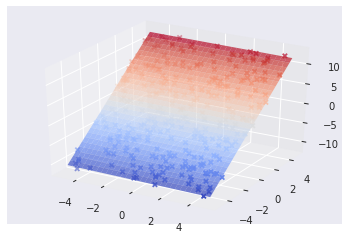

In [6]:
def _range_X(X, perc=.0):
    xmi, xma = X.min(0), X.max(0)
    ra = xma-xmi
    return xmi, xma, perc*ra

def plot_grid(X, resolution=30):
    xmi, xma, ra = _range_X(X)
    grid = np.mgrid[1:1:1j, 
                    xmi[0]-ra[0]:xma[0]+ra[0]:complex(resolution), 
                    xmi[1]-ra[1]:xma[1]+ra[1]:complex(resolution)]
    plot_X = plot_x, plot_y = grid[1:, 0] # unpack the right dimensions, have a look inside, if you are interested
    return plot_x, plot_y, plot_X.reshape(2, -1).T

def plot_predict(X, y, w, basis, predict, cmap=None, resolution=30, ax=None, alpha=.7):
    if cmap is None:
        cmap = cm.coolwarm
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    plot_x, plot_y, plot_X = plot_grid(X, resolution=resolution)
    Phi_pred = basis(plot_X)
    y_pred = predict(Phi_pred, w)
    plot_z = y_pred[:, 0].reshape(plot_x.shape)
    _ = ax.plot_surface(plot_x, plot_y, plot_z, alpha=alpha, cmap=cmap, antialiased=True, rstride=1, cstride=1, linewidth=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_predict(X, y, w_linear, linear(), predict_basis, ax=ax)
plot_data(X, y, ax=ax)

Changing basis functions
---------------------------

We have seen, that in changing the design matrix $\boldsymbol{\Phi}$ we can add additional variabels to the regression, such as the intercept with the origin. We can also change the basis to a non-linear basis, such as a polynomial basis, or a mixture of squared exponentials and any other basis we can think of. The solution to the linear regression parameters $\mathbf{w}$ will be the same, but the fit will be non-linear. 

First we will look at the polynomial basis of degree $d$

\begin{align}
\boldsymbol{\Phi} &= (\mathbf{1}, \mathbf{X}, \mathbf{X}^2, \dots, \mathbf{X}^d)\\
&= (\mathbf{X}^i)_{i=1}^d
\end{align}

and at the squared exponential basis of degree $d$ with support evenly distributed accross the domain of $\mathbf{X}$ and lengthscale $\ell$

\begin{align}
r_i &= \frac{\max\mathbf{X}_i-\min\mathbf{X}_i}{d-1}\\
\mathbf{X}'_i &= \mathbf{X}_i-\min\mathbf{X}_i\\
\boldsymbol{\Phi} &= \left(\mathbf{1},
  \exp\left\{-\frac{\mathbf{X}'_i-ir_i}{2\ell}\right\}\right)_{i=1}^d\enspace.
\end{align}

If the degree is one, we simply put one exponentiated quadratic in the center of the domain.

In [7]:
def polynomial(degree):
    def inner(X):
        if degree == 0:
            return np.ones((X.shape[0], 1))
        return _add_intercept(np.concatenate([X**(i+1) for i in range(degree)], axis=1))
    return inner

def exponentiated_quadratic(degree, lengthscale, domain):
    """
    degree: number of basis functions to use
    lengthscale: the scale of the basis functions
    domain: input X, so that the basis functions will span the domain of X
    """
    xmi, xma = domain.min(0), domain.max(0)
    ra = xma-xmi
    def inner(X):
        if degree == 0:
            return np.ones((X.shape[0], 1))
        if degree == 1:
            return _add_intercept(np.exp(-.5*((X)/lengthscale)**2))
        return _add_intercept(np.concatenate([
                    np.exp(-.5*(((X-xmi)-(float(i)*(ra/(degree-1))))/lengthscale)**2) for i in range(degree)], axis=1))
    return inner

In [8]:
def plot_basis(X, basis, w=None, plot_intercept=False, resolution=25, ax=None):
    """
    plot the `basis` in a grid with `resolution` squares around the input X.
    *args, **kwargs are passed to the basis function.
    Only in one dimension, as otherwise it gets to cluttered.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    plot_x, plot_y, plot_X = plot_grid(X, resolution=resolution)
    Phi_pred = basis(plot_X)
    if w is None:
        w = np.ones((Phi_pred.shape[1], 1))
    Phi_pred *= w.T
        
    if plot_intercept: to_plot = np.r_[0, 1:Phi_pred.shape[1]:2]
    else: to_plot = np.r_[1:Phi_pred.shape[1]:2]

    for i, z in enumerate(to_plot):
        c = cm.cool(float(i)/(2*Phi_pred.shape[1]))
        plot_z = Phi_pred[:, z]
        _ = ax.plot_surface(plot_x, plot_y, plot_z.reshape(resolution, resolution), alpha=.7, antialiased=True, color=c, rstride=1, cstride=1, linewidth=0)

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


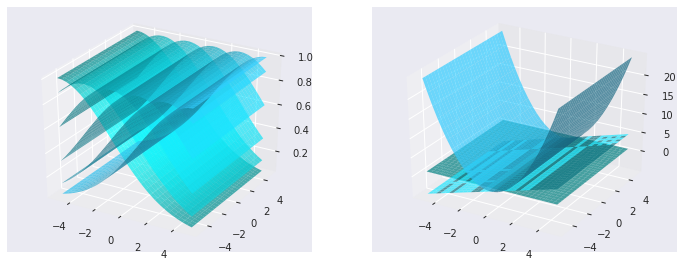

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4.5), subplot_kw=dict(projection='3d'))

plot_basis(X, exponentiated_quadratic(6, 4, X), plot_intercept=0, resolution=30, ax=ax1)
plot_basis(X, polynomial(2), plot_intercept=1, resolution=30, ax=ax2)

Now we will create some more complex (non-linear) simulated data to show the fit of the other basis functions. Also we split the data into a training and test set to show the generization property of the fitted functions.

In [10]:
y = (2.5 + (np.sin(X-2) + np.cos(.2*X) + .1*X**2 + .2*X + .01*X**3).sum(1))[:, None]
#y = (y-y.mean())/y.std()
y += np.random.normal(0, .1, (X.shape[0], 1))

X_train, X_test, y_train, y_test = cv.train_test_split(X, y, train_size=.1)

In [11]:
def optimal_ax_grid(n):
    i=1;j=1
    while i*j < n:
        if i==j or j==(i+1): j+=1
        elif j==(i+2): j-=1; i+=1
    return i,j
            
def plot_fits(X_train, y_train, X_test, y_test, basis_gen, predict, degrees, fit=fit_linear, figsize=None):
    i, j = optimal_ax_grid(len(degrees))
    fig, axes = plt.subplots(i, j, figsize=figsize, subplot_kw=dict(projection='3d'))
    axes = axes.flat
    errors = pd.DataFrame(columns=pd.MultiIndex.from_product([['train', 'test'], ['RMSE', 'StdE']]))
    for i, d in enumerate(degrees):
        basis = basis_gen(d)
        Phi = basis(X_train)
        w_fit, var = fit(Phi, y_train)
        StdE, RMSE = _e = error(y_train, predict(Phi, w_fit))
        Phi_test = basis(X_test)
        StdE_test, RMSE_test = _e_test= error(y_test, predict(Phi_test, w_fit))
        errors.loc[d, ['train']] = _e[::-1]
        errors.loc[d, ['test']] = _e_test[::-1]
        ax = axes[i]
        plot_predict(X_train, y_train, w_fit, basis, predict, ax=ax)
        plot_data(X_train, y_train, ax=ax, marker='o', label='train', edgecolors='k')
        plot_data(X_test, y_test, ax=ax, marker='o', label='test', edgecolors='w')
        ax.set_title('degree={}\nTrain StdE={:.4f}\nTest StdE={:.4f}'.format(d, StdE, StdE_test))
        ax.legend()
    return errors

In [12]:
degrees = np.arange(1,10,1)

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


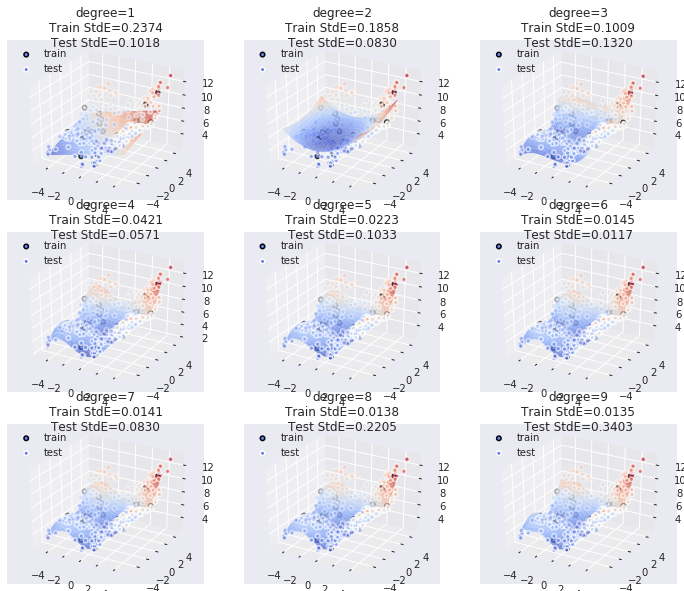

In [13]:
poly_errors = plot_fits(X_train, y_train, X_test, y_test, polynomial, predict_basis, degrees=degrees, figsize=(12,10))

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


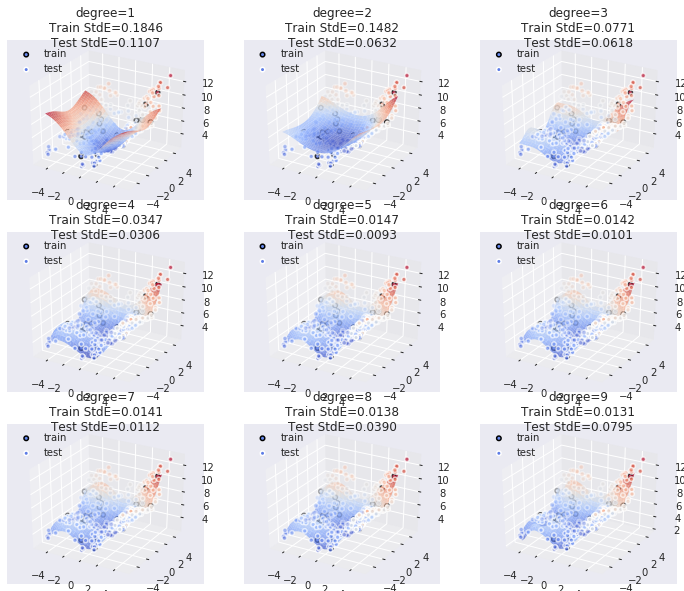

In [14]:
eq_errors = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis, degrees=degrees, figsize=(12,10))

In [15]:
linear_df = pd.concat((eq_errors.T, poly_errors.T), keys=['eq', 'poly']).reset_index(0)
#eq_errors.plot(kind='bar', ax=ax, label='eq')
#.plot(kind='bar', ax=ax, label='poly', xlabel='degree')
_c = linear_df.columns.tolist(); _c[0] = 'basis'; linear_df.columns=_c
#df.reset_index()
linear_df = linear_df.reset_index().set_index(['basis', 'level_0', 'level_1']).T

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


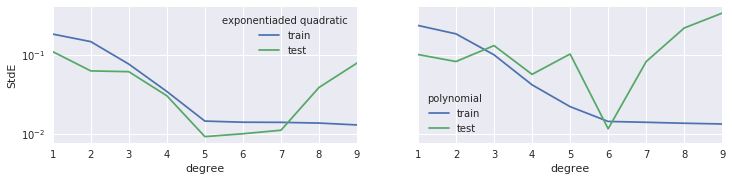

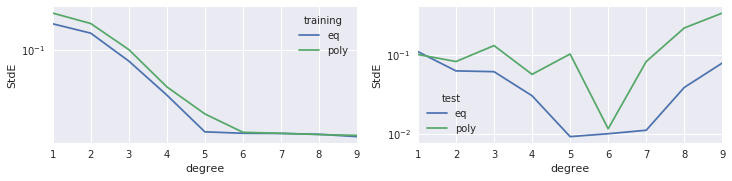

In [16]:
fig, [ax1, ax2] = fig, axes = plt.subplots(1,2,figsize=(12, 2.5), sharex=True, sharey=True)
fig, [ax3, ax4] = fig, axes = plt.subplots(1,2,figsize=(12, 2.5), sharex=True, sharey=False)

linear_df.index.name='degree'

eq_df = linear_df['eq'].xs('StdE', level=1, axis=1)
eq_df.columns.name = 'exponentiaded quadratic'
eq_df.plot(kind='line', ax=ax1)

poly_df = linear_df['poly'].xs('StdE', level=1, axis=1)
poly_df.columns.name = 'polynomial'
poly_df.plot(kind='line', ax=ax2)

train_df = linear_df.xs('train', level=1, axis=1).xs('StdE', level=1, axis=1)
train_df.columns.name = 'training'
train_df.plot(kind='line', ax=ax3)

test_df = linear_df.xs('test', level=1, axis=1).xs('StdE', level=1, axis=1)
test_df.columns.name = 'test'
test_df.plot(kind='line', ax=ax4)

ax1.set_ylabel('StdE')
ax2.set_ylabel('StdE')
ax3.set_ylabel('StdE')
ax4.set_ylabel('StdE')
ax1.axes.set_yscale('log')
ax2.axes.set_yscale('log')
ax3.axes.set_yscale('log')
ax4.axes.set_yscale('log')

Thus, we can do non-linear regression using the trick of transforming the input space into different dimensions and solving the linear system in the high dimensional space. 

Bayesian Regression
----------------------

Now that we have seen how linear regression works, we can go on to the Bayesian persective of linear regression. We can write the linear regression problem in a Bayesian way by adding a noise term, which is a stochastic variable

\begin{align}
\mathbf{y} &= \boldsymbol{\Phi}\mathbf{w} + \varepsilon\\
\varepsilon &\sim \mathcal{N}(0, \sigma^2\mathbf{I})\enspace.
\end{align}

Additionally we define a prior over the parameters $\mathbf{w}$, which deals as our prior belief of the distribution over the parameters $\mathbf{w}$

\begin{align}
\mathbf{w} &\sim \mathcal{N}(\mathbf{0}, \alpha\mathbf{I})\enspace.
\end{align}

Using Bayes theorem, we can compute the posterior distribution over $\mathbf{w}$ given the data, by computing the posterior distribution given the data $\boldsymbol{\Phi}, \mathbf{y}$

\begin{align}
p(\mathbf{w}|\boldsymbol{\Phi}, \mathbf{y}) &\propto p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w})p(\mathbf{w})\\
&= \mathcal{N}(\mathbf{y}|\boldsymbol{\Phi}\mathbf{w}, \sigma^2\mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha\mathbf{I})\\
&= \mathcal{N}(\mathbf{w}|\boldsymbol{\mu}, \mathbf{C}) \cdot \text{const.}\\
\mathbf{C} &= (\sigma^{-2}\boldsymbol{\Phi}^\top\boldsymbol{\Phi}+\alpha^{-1}\mathbf{I})^{-1}\\
\boldsymbol{\mu} &= \sigma^{-2}\mathbf{C}\boldsymbol{\Phi}^\top\mathbf{y}
\end{align}

The close relationship to the linear regression solution should be visible immediately, another indication that any deterministic expression is a special case of a more general probabilistic expression. The additional parameters of the probabilistic expression are prior belief, first the output variable noise $\sigma^2$ and the prior belief about the spread of parameters $\mathbf{w}$, which we called $\alpha$. 

We can implement this way of solving the system as shown below. We assume a noise variance of $\sigma=0.01$ and a prior spread of parameters of $\alpha=20.0$

In [17]:
# convenience function to solve the Baysian linear system using the design matrix Phi
def fit_bayesian(Phi, y, sigma=.1, alpha=20):
    Cinv = (Phi.T.dot(Phi)/sigma**2 + np.eye(Phi.shape[1])/alpha)
    return np.linalg.solve(Cinv, Phi.T.dot(y)/sigma**2), np.linalg.inv(Cinv)

In [18]:
basis = exponentiated_quadratic(10, 4, X)
Phi = basis(X)
w_linear = fit_linear(Phi, y)
w_bayesian, w_cov = fit_bayesian(Phi, y)

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


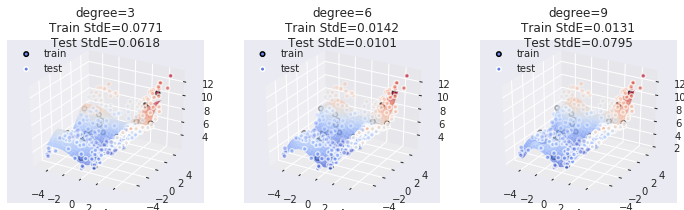

In [19]:
linear_error = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis,
                         degrees=np.arange(3, 10, 3), 
                         figsize=(12,3), 
                         fit=fit_linear)

In [20]:
bayesian_errors = pd.DataFrame(columns=['degree', 'sigma', 'split', 'RMSE', 'StdE'])
def concat_be(bayesian_errors, _be, sigma):
    _be.index.name='degree'
    _be = _be[['test', 'train']].stack(0).reset_index(1)
    _be['sigma'] = sigma
    _be = _be.rename(columns=dict(level_1='split'))
    return pd.concat((bayesian_errors, _be.reset_index()), axis=0)

Bayesian fit with noise variance of 0.2


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


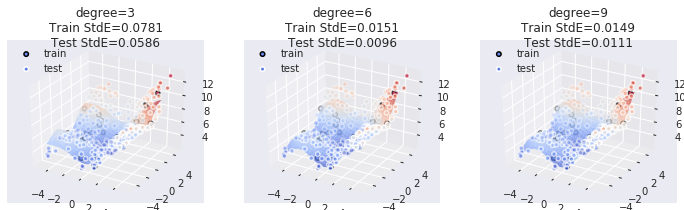

In [21]:
sigma = .2
print('Bayesian fit with noise variance of {}'.format(sigma))
_be = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis,
                            degrees=np.arange(3, 10, 3),
                            figsize=(12,3), 
                            fit=lambda X, y: fit_bayesian(X, y, sigma=sigma))
bayesian_errors = concat_be(bayesian_errors, _be, sigma)

Bayesian fit with noise variance of 0.1


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


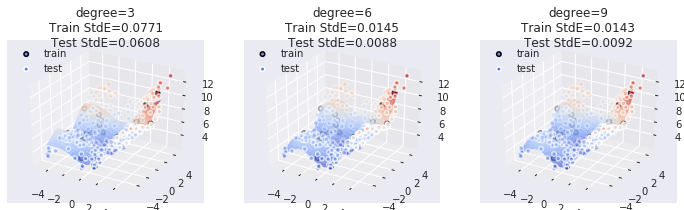

In [22]:
sigma = .1
print('Bayesian fit with noise variance of {}'.format(sigma))
_be = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis,
                            degrees=np.arange(3, 10, 3),
                            figsize=(12,3), 
                            fit=lambda X, y: fit_bayesian(X, y, sigma=sigma))
bayesian_errors = concat_be(bayesian_errors, _be, sigma)

Bayesian fit with noise variance of 0.01


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


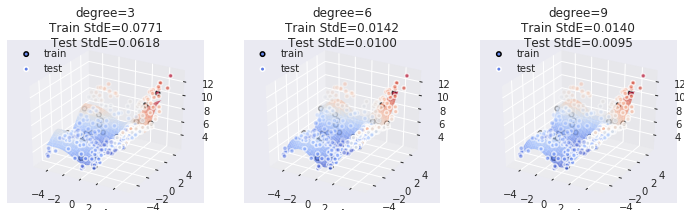

In [23]:
sigma = .01
print('Bayesian fit with noise variance of {}'.format(sigma))
_be = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis, 
                            degrees=np.arange(3, 10, 3),
                            figsize=(12,3), 
                            fit=lambda X, y: fit_bayesian(X, y, sigma=sigma))
bayesian_errors = concat_be(bayesian_errors, _be, sigma)

Bayesian fit with noise variance of 0.001


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


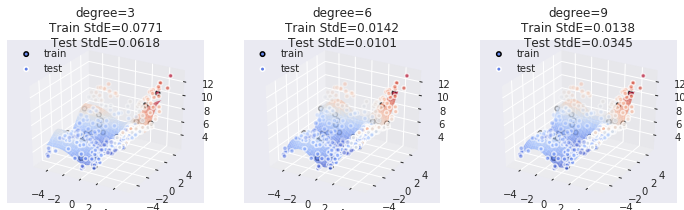

In [24]:
sigma = .001
print('Bayesian fit with noise variance of {}'.format(sigma))
_be = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis, 
                            degrees=np.arange(3, 10, 3),
                            figsize=(12,3), 
                            fit=lambda X, y: fit_bayesian(X, y, sigma=sigma))
bayesian_errors = concat_be(bayesian_errors, _be, sigma)

Bayesian fit with noise variance of 1e-10


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


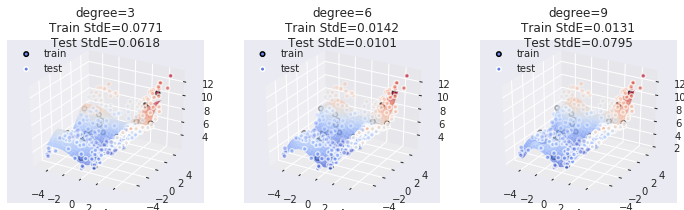

In [25]:
sigma = 1e-10
print('Bayesian fit with noise variance of {}'.format(sigma))
_be = plot_fits(X_train, y_train, X_test, y_test, lambda d: exponentiated_quadratic(d, 2, X), predict_basis, 
                            degrees=np.arange(3, 10, 3),
                            figsize=(12,3), 
                            fit=lambda X, y: fit_bayesian(X, y, sigma=sigma))
bayesian_errors = concat_be(bayesian_errors, _be, sigma)

As one can see, the $\sigma$ parameter induces intrinsic noise in the process and relaxes the fit to the data. This can be seen as a principled, based on probabilistic assumptions penalization of overfitting. Let us see the effect of sigma on the fit:

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


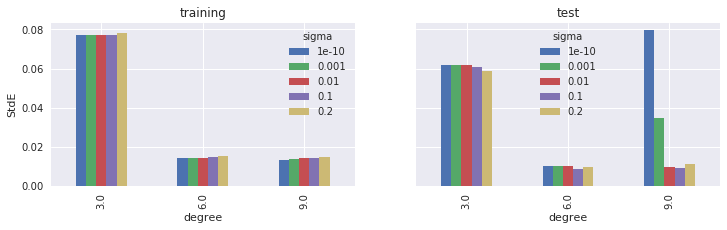

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 3), sharex=True, sharey=True)
tmp = bayesian_errors[bayesian_errors['split']=='train'][['StdE', 'sigma', 'degree']].set_index(['sigma', 'degree'])
tmp = tmp.unstack(level=0)
tmp.columns = tmp.columns.droplevel()
tmp.plot(kind='bar', ax=ax1)

tmp = bayesian_errors[bayesian_errors['split']=='test'][['StdE', 'sigma', 'degree']].set_index(['sigma', 'degree'])
tmp = tmp.unstack(level=0)
tmp.columns = tmp.columns.droplevel()
tmp.plot(kind='bar', ax=ax2)
ax1.set_ylabel('StdE')

ax1.set_title('training')
ax2.set_title('test')

The model with $\sigma=10^{-10}$ is equivalent to a noise less linear model and therefore comparable to the linear fit without bayesian treatment. We can see that the more basis functions we add in the bayesian fit, we get less test error, but the non-bayesian solution starts to overfit, when highering the number of basis functions. The 3 best fits according to this small cross-validation are shown below

In [27]:
bayesian_errors[bayesian_errors['split']=='test'].sort_values(by=['StdE', 'RMSE']).head(3)

,RMSE,StdE,degree,sigma,split
2,0.14451,0.00881093,6.0,0.10,test
4,0.151109,0.00921326,9.0,0.10,test
4,0.155164,0.00946051,9.0,0.01,test


Gaussian Process with Basis Functions
------------------

In order to get from the linear parametric model to an non-parametric (better: infinite-parameter) model, we maximize the (log-)likelihood of the output data given the inputs w.r.t. the hyperparameters, which are the parameters of the prior distributions we put over the parameters. The parameters $\mathbf{w}$ get integrated over, which implies, that we take all possible values of $\mathbf{w}$ into account in the maximum likelihood solution.

\begin{align}
p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma) &= \int p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha) \,\mathrm{d}\mathbf{w}\\
&= \langle\mathcal{N}(\mathbf{y}|\boldsymbol{\Phi}\mathbf{w}, \sigma^2\mathbf{I})\rangle_{\mathcal{N}(\mathbf{0}, \alpha\mathbf{I})}\\
&= \mathcal{N}(\mathbf{y}|\mathbf{0}, \alpha\boldsymbol{\Phi}\boldsymbol{\Phi}^\top + \sigma^2\mathbf{I})
\end{align}

Thus, we can maximize this marginal likelihood w.r.t. the hyperparameters $\alpha, \sigma$ by log transforming and maximizing:

\begin{align}
\hat\alpha, \hat\sigma = \mathop{\arg\max}_{\alpha, \sigma}\log p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma)
\end{align}

This will choose the most likely hyperparameters $\alpha, \sigma$ for the data to be explained by the basis set spanned by the covariance matrix $\boldsymbol{\Phi}\boldsymbol{\Phi}^\top$. Basically $\alpha$ and $\sigma$ are tradeoff parameters, between random noise $\sigma$ and datafit $\alpha$. 

Here we have seen how a Gaussian process can be defined using a design matrix $\boldsymbol\Phi$. Let us see how well this model works and if it chooses the right parameters $\alpha, \sigma$. We will use GPy to do the job for us, where all of these methods are implemented. We will use the fixed covariance structure, spanned by our bases $\boldsymbol\Phi$ and optimize the parameters.

In [28]:
Phi = basis(X_train)
kernel = GPy.kern.Fixed(2, Phi.dot(Phi.T))
kernel.name = 'data'
kernel.variance.name = 'alpha'
m_max_lik = GPy.models.GPRegression(X_train, y_train, kernel)
m_max_lik.likelihood.name = 'noise'
m_max_lik.likelihood.variance.name = 'sigma'

In [29]:
m_max_lik.optimize()

In [30]:
m_max_lik

GP_regression.,value,constraints,priors
data.alpha,662.99671533,+ve,
noise.sigma,0.02775116544,+ve,


But now we do not have the parameters anymore, which we used for predicting at newly seen inputs and compare to the test data. We can either use above formula to compute the the probability over $\mathbf{w}$ as before, providing the uncertainty over the parameters

\begin{align}
p(\mathbf{w}|\boldsymbol{\Phi}, \mathbf{y}) &\propto \mathcal{N}(\mathbf{w}|\boldsymbol{\mu}, \mathbf{C}) \cdot \text{const.}\\
\mathbf{C} &= (\sigma^{-2}\boldsymbol{\Phi}^\top\boldsymbol{\Phi}+\alpha^{-1}\mathbf{I})^{-1}\\
\boldsymbol{\mu} &= \sigma^{-2}\mathbf{C}\boldsymbol{\Phi}^\top\mathbf{y}\enspace,
\end{align}

or we predict using the distribution over $\mathbf{y}|\boldsymbol{\Phi}$.

In [31]:
Phi = basis(X_train)
Phi_test = basis(X_test)

In [32]:
def predict_max_lik(Phi_test, w):
    return (m_max_lik.kern.variance) * Phi_test.dot(Phi.T.dot(m_max_lik.posterior.woodbury_vector))

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


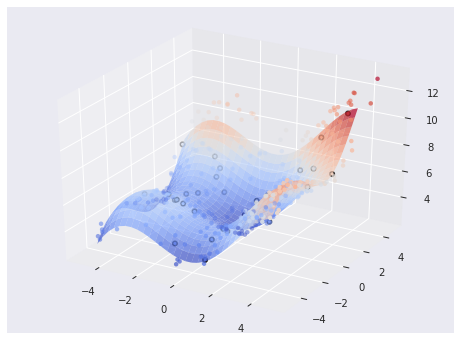

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection='3d'))
plot_predict(X_train, y_train, None, basis, predict_max_lik, ax=ax)
plot_data(X_train, y_train, ax=ax, marker='o', label='train', edgecolors='k')
plot_data(X_test, y_test, ax=ax, marker='o', label='test', edgecolors='none')

In [34]:
max_lik_pred = predict_max_lik(Phi_test, None)
max_likelihood_StdE, max_likelihood_RMSE = error(y_test, max_lik_pred)

In [35]:
mu, var = fit_bayesian(Phi, y_train, sigma=np.sqrt(m_max_lik.likelihood.variance[0]), alpha=m_max_lik.kern.variance[0])
std = np.sqrt(np.diagonal(var))

w_realizations = np.empty((mu.shape[0], 9))
for i in range(w_realizations.shape[1]):
    w_realization = np.random.multivariate_normal(mu[:, 0], var)[:, None]
    w_realizations[:, i] = w_realization[:,0]

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


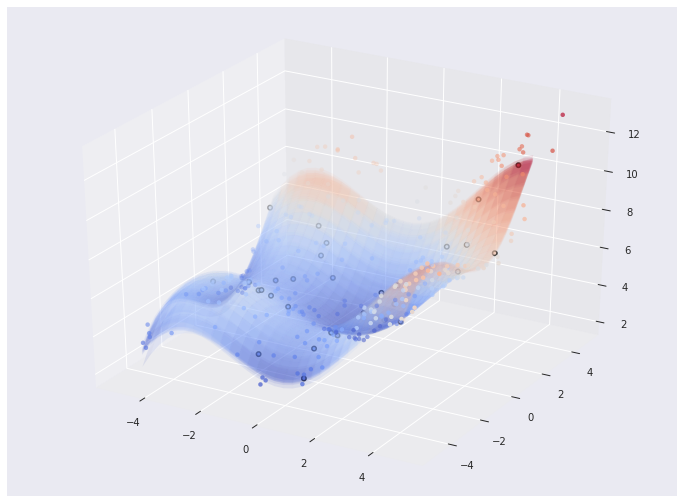

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(12,9), subplot_kw=dict(projection='3d'))
for i in range(9):
    ax = axes
    plot_predict(X_train, y_train, w_realizations[:, [i]], basis, predict_basis, ax=ax, alpha=.1)
plot_data(X_train, y_train, ax=ax, marker='o', label='train', edgecolors='k')
plot_data(X_test, y_test, ax=ax, marker='o', label='test', edgecolors='none')

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


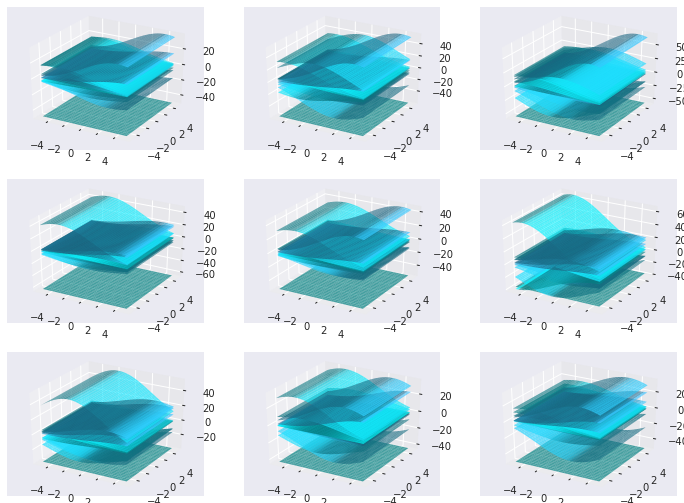

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(12,9), subplot_kw=dict(projection='3d'))
for i in range(w_realizations.shape[1]):
    ax = axes.flat[i]
    plot_basis(X_test, basis, w_realizations[:, i], plot_intercept=1, resolution=30, ax=ax)

Gaussian Process
------------------

As we have seen, we can fit the hyperparameters using the maximum likelihood solution, without the need to do a cross-validation over possible parameter values. We can further generalize this idea to the covariance matrix $\boldsymbol\Phi\boldsymbol\Phi^\top$ by replacing the entries of the covariance matrix by a kernel function between the inputs, which correspond to a dot product in a higher dimensional space $\mathbf{K}_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$. The only requirement for this covariance function is to produce a semi-positive definite matrix $\mathbf{K}$, as it needs to be inverted in the learning as well as prediction step of GP regression.

In [38]:
k = GPy.kern.RBF(2, ARD=0) + GPy.kern.Bias(2) + GPy.kern.Linear(2, ARD=0)
m = GPy.models.GPRegression(X_train, y_train, k)
m.optimize()
y_pred_gp, y_pred_gp_var = m.predict(X_test)
gp_StdE, gp_RMSE = error(y_test, y_pred_gp)
m

GP_regression.,value,constraints,priors
sum.rbf.variance,5.76826060534,+ve,
sum.rbf.lengthscale,2.66598858308,+ve,
sum.bias.variance,39.1714545327,+ve,
sum.linear.variances,0.254203412803,+ve,
Gaussian_noise.variance,0.0120503636458,+ve,


 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


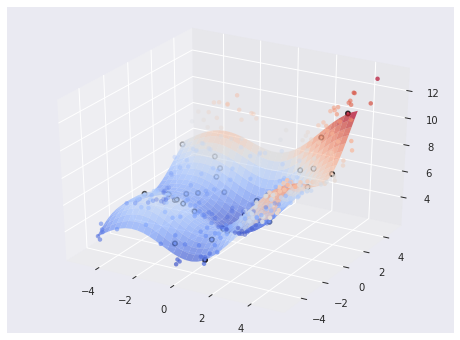

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection='3d'))
basis = lambda x: x
def predict_gp(X, w):
    return m.predict(X)[0]
plot_predict(X_train, y_train, None, basis, predict_gp, ax=ax)
plot_data(X_train, y_train, ax=ax, marker='o', label='train', edgecolors='k')
plot_data(X_test, y_test, ax=ax, marker='o', label='test', edgecolors='none')

Now we can compare the fits we have made so far against each other:

 /home/travis/install/Miniconda3-latest-Linux-x86_64-3.5/envs/bayesian_linear_regression/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


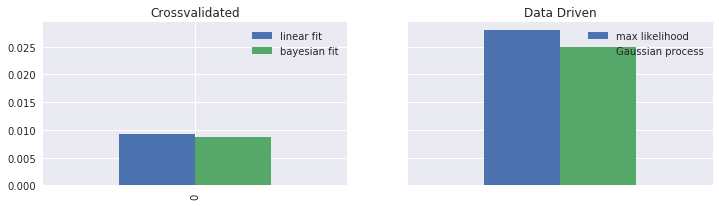

In [40]:
comparison = pd.DataFrame(columns=['linear fit', 'bayesian fit', 'max likelihood'])
comparison['linear fit'] = [linear_df['eq']['test'].min(0).loc['StdE']]
comparison['bayesian fit'] = bayesian_errors[bayesian_errors.split=='test'].min(0).loc['StdE']
comparison['max likelihood'] = max_likelihood_StdE
comparison['Gaussian process'] = gp_StdE
fig, axes = plt.subplots(1, 2, figsize=(12,3), sharey=True)
comparison[['linear fit', 'bayesian fit']].plot(kind='bar', title='Crossvalidated', ax=axes[0])
comparison[['max likelihood', 'Gaussian process']].plot(kind='bar', title='Data Driven', ax=axes[1])
plt.ylabel('StdE')
_ = plt.xticks([])

The conclusion is, that the linear method can be seen from a Bayesian perspective by defining priors over the parameters and integrating them out. In the linear and Bayesian linear regression case, we need to crossvalidate the parameters according to our test set. This can be challenging, as we need to know th space in which the paramaters occur most likely and choose a fine enough grid to fit the data. This selection can be beneficial, as we see above, but if we do not know the test data, or have not enough samples to split our data into train and test split we need to do a model based data driven approach. On the right hand side of the above plot, we can see the data driven, not crossvalidation dependend solutions, where we maximize the likelihood to see the data under our model. 

In both cases, we can see that going into the direction of Bayesian modelling brings an advantage over the non-Bayesian approaches, as we include an intrinsic random error in the model and it can model the underlying function in more detail. 

The design matrix trick brought us to the non-linear world from a simple linear fit of the data. Note, that the *model* is still linear, but the transformation of the *input space* allows us to go non-linear!

The Bayesian approach allowed us to go from a simple linear model to a well defined regularized model, which gives us the advantage of incorporating a distribution over the parameters of the linear fit in our solution.

Going through with the Bayesian approach, we saw that the covariance of design matrix can be seen as a covariance function, which then allowed for (implicitly) infinite design matrix dimensions and with that infinite basis functions. 

In the next notebook [Parametric non parametric GPs](./../GPy/ParametricNonParametricInference.ipynb) we will have a look, how to incorporate both worlds, parametric models based on design matrices and Gaussian process fits with infinite bases.